# Assembly Tree Generation and Evaluation

## Formulation
 - State Space S = {Every Possible Subassembly}
 - Action Space A = {Every Connection that can currently be removed}
 - P(s'|s,a) = Feasability Checks
 - R(s,a) = Cost of removing a certain + the 
 - Graph Assumption for modelling the 

## Notes
 - Next Steps:
     - Randomly generate rewards and show pathing possible
     - Rewards as a distance cost


In [3]:
import sys, random, pydot, math
import pprint as pp
import networkx as nx
import matplotlib.pyplot as plt
from pyvis.network import Network
from networkx.drawing.nx_pydot import graphviz_layout

In [4]:
# Initialize the inputs (will later read in from file [JSON])
numAgents = 1
numParts = 4
numConnections = int(numParts*(numParts-1)/2)
numActions = int(sum([math.factorial(numConnections)/math.factorial(i) for i in range(0, numConnections)]))
numStates = numActions-1

#SEQUENCING CONSTRAINTS (will later read in from file [JSON])
# Of the format {connection touple: connection touple that must be remove first}

# seqConstraint = {}
seqConstraint = {(0, 2): (0, 1),
                 (1, 3): (2, 3),
                 (1, 2): (1, 3),
                 (0, 1): (0, 2)}

print("CONFIGURATION: \n\t%d Parts,\n\t%d Connections in Assembly,\n\t%d Potential Subassemblies, \n\t%d Potential Edges, \n\t%d Sequential Constraints"\
     % (numParts, numConnections, numStates, numActions, len(seqConstraint)))

CONFIGURATION: 
	4 Parts,
	6 Connections in Assembly,
	1955 Potential Subassemblies, 
	1956 Potential Edges, 
	4 Sequential Constraints


In [5]:
# Initialize the inputs (will later read in from file [JSON])
numAgents = 1
numParts = 3
numConnections = int(numParts*(numParts-1)/2)
numActions = int(sum([math.factorial(numConnections)/math.factorial(i) for i in range(0, numConnections)]))
numStates = numActions-1

#SEQUENCING CONSTRAINTS (will later read in from file [JSON])
# Of the format {connection touple: connection touple that must be remove first}

seqConstraint = {}
# seqConstraint = {(0, 2): (0, 1),
#                  (1, 3): (2, 3),
#                  (1, 2): (1, 3),
#                  (0, 1): (0, 2)}

print("CONFIGURATION: \n\t%d Parts,\n\t%d Connections in Assembly,\n\t%d Potential Subassemblies, \n\t%d Potential Edges, \n\t%d Sequential Constraints"\
     % (numParts, numConnections, numStates, numActions, len(seqConstraint)))

CONFIGURATION: 
	3 Parts,
	3 Connections in Assembly,
	14 Potential Subassemblies, 
	15 Potential Edges, 
	0 Sequential Constraints


# HELPER FUNCTIONS

In [ ]:
# HTML VERSION Drawing
def plotVis(G):
    if(len(G.nodes[1]) > 1):
        newLabs = {}
        for i in G.nodes:
            newLabs[i] = G.nodes[i]['value'].getNCL()
            del G.nodes[i]['value']
        nx.relabel_nodes(G, newLabs, copy=True)
    
    net = Network(notebook=True)
    net.from_nx(G)
    name = str("NumParts=" + str(numParts) + " and NumConstraints=" + str(len(seqConstraint)) + ".html")
    net.show(name)

    
def hierarchy_pos(G, root=None, width=20., vert_gap = 0.4, vert_loc = 0, xcenter = 0.5):  
    # From Joel's answer at https://stackoverflow.com/a/29597209/2966723.  
    def _hierarchy_pos(G, root, width=1., vert_gap = 0.2, vert_loc = 0, xcenter = 0.5, pos = None, parent = None):   
        if pos is None:
            pos = {root:(xcenter,vert_loc)}
        else:
            pos[root] = (xcenter, vert_loc)
        children = list(G.neighbors(root))
        if not isinstance(G, nx.DiGraph) and parent is not None:
            children.remove(parent)  
        if len(children)!=0:
            dx = width/len(children) 
            nextx = xcenter - width/2 - dx/2
            for child in children:
                nextx += dx
                pos = _hierarchy_pos(G,child, width = dx, vert_gap = vert_gap, 
                                    vert_loc = vert_loc-vert_gap, xcenter=nextx,
                                    pos=pos, parent = root)
        return pos          
    return _hierarchy_pos(G, root, width, vert_gap, vert_loc, xcenter)


# Generating Subassemblies in a recursive manner
def recurGen(p, subA, G):
    currCon = list(subA.H.edges())
    if(len(currCon) > 0):
        i = G.number_of_nodes() + 1
        for c in currCon:
            newSubA = subA.copy()
            newSubA.H.remove_edges_from([c])
            if(c in seqConstraint.keys() and seqConstraint[c] in newSubA.H.edges()):
                pass # This means a feasability constraint has been failed!
            else:
                G.add_node(i, value=newSubA)
                G.add_edge(p,i, a=c, r=R(p,c))
                G = recurGen(i, newSubA, G)
            
            i = G.number_of_nodes() + 1
        return G
    else:
        return G

# Checking Feasability
def P(sN, s, a):
    # Geometric Feasability
    pass

    # 


Rewards = {i: random.randint(0, 10) for i in range(numConnections)}
def genRewards(assembled):
    Rewards = {i: random.randint(0, 10) for i in list(assembled.H.edges())}
    print(Rewards)

def R(s, a):
    return Rewards[a]

## Preliminary Code (Object Classes)

In [ ]:
class part:
    def __init__(self, number):
        self.num = number
        self.length = 1
        self.width = 1
        self.pos = []
        self.vel = []
    
    def toJSON(self):
        return json.dumps(self, default=lambda o: o.__dict__, sort_keys=True, indent=4)
    def __str__(self):
        return "Part " + str(self.num)
    def __repr__(self):
        return "Part " + str(self.num)

    
class subAssembly:
    def __init__(self):
        self.H = nx.Graph()
    
    def copy(self):
        new = subAssembly()
        new.H = self.H.copy()
        return new
    
    def getNCL(self):
        return str(len(list(self.H.edges())))
    
    def toJSON(self):
        return json.dumps(self, default=lambda o: o.__dict__, sort_keys=True, indent=4)
    def __str__(self):
        return "Number of Connections Left " + getNCL()
    def __repr__(self):
        return "NCL: " + getNCL()

## Running the Assembly Generation

In [ ]:
# Simple initial initialization (will later read in from file [JSON])
assembled = subAssembly()
for i in range(numParts):
    n = part(i)
    assembled.H.add_node(i, value=n)
    assembled.H.add_edges_from([(i,j) for j in range(numParts) if i != j])
print(list(assembled.H.edges()))
genRewards(assembled)

# Initialize the assembly graph
G = nx.DiGraph()
G.add_node(1, value=assembled)
G = recurGen(1, assembled, G)

print("DONE: %d Nodes and %d Edges" % (G.number_of_nodes(), G.number_of_edges()))

# Graphing Suite

DONE: 16 Nodes and 15 Edges


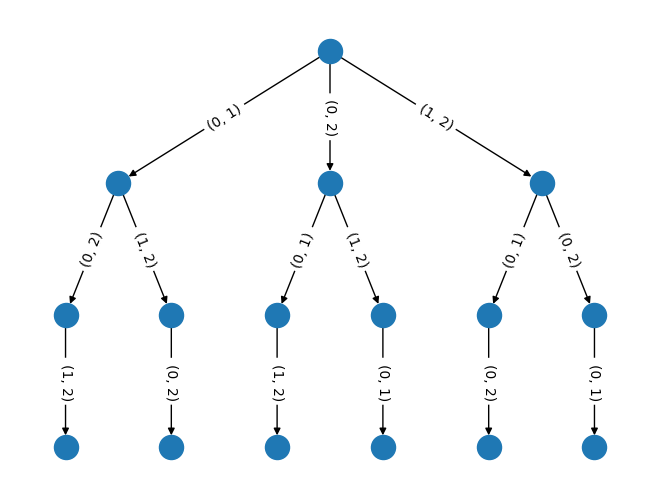

In [8]:
try:
    pos = hierarchy_pos(G,1)
except:
    pos = nx.planar_layout(G)
actions = nx.get_edge_attributes(G,'a')
nx.draw(G, pos, font_color="#FFFFFF")
nx.draw_networkx_edge_labels(G, pos, edge_labels = actions)
#nx.draw(G, with_labels=True, font_color="#FFFFFF")

print("DONE: %d Nodes and %d Edges" % (G.number_of_nodes(), G.number_of_edges()))

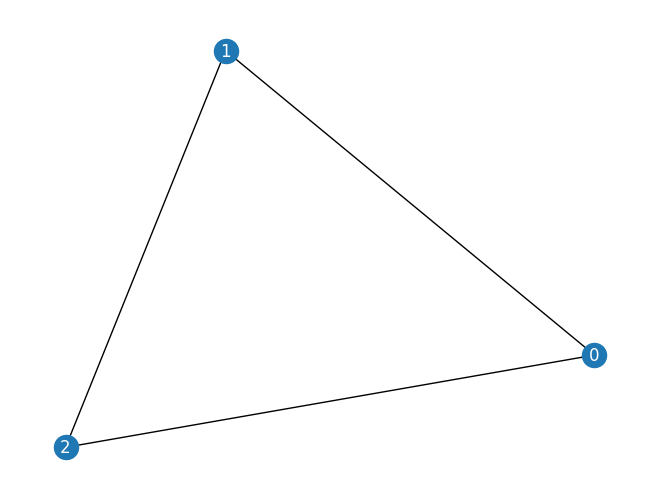

In [9]:
nx.draw(assembled.H, with_labels=True, font_color="#FFFFFF")

In [10]:
V = G.copy()
try:
    plotVis(V)
except:
    try:
        plotVis(V)
    except:
        print("Nope!")

Local cdn resources have problems on chrome/safari when used in jupyter-notebook. 
Local cdn resources have problems on chrome/safari when used in jupyter-notebook. 
